# Notebook 3 : Creation of a full model of Machine Learning CLassification

Improving the model and trying Deep Learning.

In [3]:
import numpy as np
import pandas as pd 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [5]:
df = pd.read_csv("data.csv", index_col = 'index')
df.head()

,title,genre,summary
index,,,
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


## Preprocessing with functions

In [6]:
from preprocessing import preprocess_text, remove_freqwords, remove_rarewords
from collections import Counter

#### Preprocessing with updated function to simplify a maximum the words and their use

In [7]:
df['processed'] = df['summary'].apply(preprocess_text) 

join_column = " ".join(df['processed'])
split_column = join_column.split(' ')

cnt = Counter(split_column)
most_common = cnt.most_common()

FREQWORDS = [w for (w, word_count) in most_common[:20]]

RAREWORDS = [word for word, frequency in most_common if frequency == 1]

df["pross_freq"] = df["processed"].apply(remove_freqwords, args = [FREQWORDS])
df["pross_freq_rare"] = df["pross_freq"].apply(remove_rarewords, args = [RAREWORDS])

In [8]:
class_labels = ['fantasy', 'science', 'crime', 'history', 'horror', 'thriller', 'psychology', 'romance', 'sports', 'travel']

## Creation of the Model Class

Modification of the pipeline so it takes in account SMOTE to oversample. We are oversampling the datas because of the imbalanced classes. I also tried undersampling but after testing it wasn't as efficient. 

In [9]:
class Model:
    def __init__(self, X, y, model_architecture, vectorizer, random_seed=42, test_size=0.2) -> None:
        self.X = X
        self.y = y
        self.model_instance = model_architecture
        self.vectorizer = vectorizer
        self.random_seed = random_seed
        self.test_size = test_size

        # the pipeline as defined previously
        self.pipeline = make_pipeline(
            self.vectorizer,                        
            SMOTE(random_state=self.random_seed),  
            self.model_instance                    
        )

        # train test split using the above X, y, test_size and random_state
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_seed)
    
    def fit(self):
        # fit self.pipeline to the training data
        self.pipeline.fit(self.X_train, self.y_train)
        
    def predict(self):
        return self.pipeline.predict(self.X_test)

    def predict_proba(self):
        return self.pipeline.predict_proba(self.X_test)

    def class_report(self, class_labels):
        # the report function as defined previously
        print(classification_report(self.y_test, self.predict(), target_names=class_labels))
        confusion_matrix1 = confusion_matrix(self.y_test, self.predict())

        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

## Testing of the SMOTE oversampling

Testing it before implementing it so I am more confortable with its usage. 

In [53]:
label_encoder = LabelEncoder() 
# fit and transform the encoder on labels
df['genre_enc'] = label_encoder.fit_transform(df['genre'])

# Split the data into training and testing sets
X = df["pross_freq_rare"]
y = df['genre_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [54]:
vectorizer = CountVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [12]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)


## Checking if it worked and the results

Class=8, n=825 (10.000%)
Class=3, n=825 (10.000%)
Class=7, n=825 (10.000%)
Class=1, n=825 (10.000%)
Class=2, n=825 (10.000%)
Class=6, n=825 (10.000%)
Class=0, n=825 (10.000%)
Class=4, n=825 (10.000%)
Class=5, n=825 (10.000%)
Class=9, n=825 (10.000%)


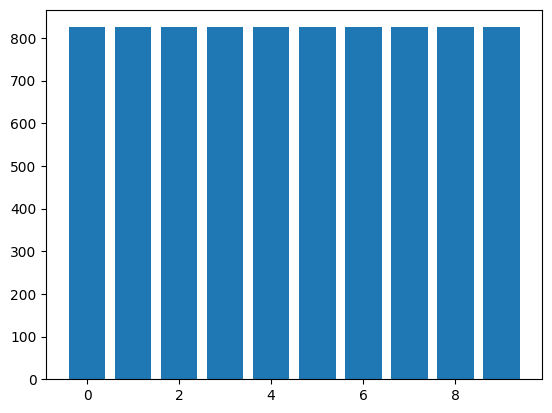

In [13]:
# summarize distribution
counter = Counter(y_train_resampled)
for k,v in counter.items():
 per = v / len(y_train_resampled) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

## Finding the best classifier and the best vectorizer

I want to find the best classifier and vectorizer combination. As a result we have 'MultinomialNB' and 'Countvectorizer'. 

In [50]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [51]:

models = {
    'SVC': {'model': SVC(random_state=42)},
    'KNN': {'model': KNeighborsClassifier()},
    'XGBoost': {'model': XGBClassifier(random_state=42)},
    'LogisticRegression': {'model': LogisticRegression()},
    'RandomForest': {'model': RandomForestClassifier(random_state=42)},
    'NaiveBayes': {'model': MultinomialNB()},
    'GradientBoosting': {'model': GradientBoostingClassifier(random_state=42)},
    'DecisionTree': {'model': DecisionTreeClassifier(random_state=42)},
    'SVM_Poly': {'model': SVC(kernel='poly',random_state=42)},
    'KNN_Weighted': {'model': KNeighborsClassifier(weights='distance')},
}

vectorizers = {
    'Count': {'vectorizer': CountVectorizer()},
    'TF-IDF': {'vectorizer': TfidfVectorizer()},
    # 'Word2Vec': {'vectorizer': None}
}

SVC Count
SVC TF-IDF
KNN Count
KNN TF-IDF


/Users/isaurestiffel/Doc_locaux/cours-EPF/2023-2024/NLP/nlp_project/myenv/lib/python3.10/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


XGBoost Count
XGBoost TF-IDF
LogisticRegression Count


/Users/isaurestiffel/Doc_locaux/cours-EPF/2023-2024/NLP/nlp_project/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression TF-IDF
RandomForest Count
RandomForest TF-IDF
NaiveBayes Count
NaiveBayes TF-IDF
GradientBoosting Count
GradientBoosting TF-IDF
DecisionTree Count
DecisionTree TF-IDF
SVM_Poly Count
SVM_Poly TF-IDF
KNN_Weighted Count
KNN_Weighted TF-IDF
Best model: NaiveBayes
Best vectorizer: Count
accuracy_score: 0.6727467811158798

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.64      0.73       109
           1       0.85      0.71      0.78       196
           2       0.75      0.74      0.74       118
           3       0.55      0.60      0.58       113
           4       0.00      0.00      0.00        26
           5       0.00      0.00      0.00        17
           6       0.61      0.77      0.68       120
           7       0.80      0.31      0.44        13
           8       0.57      0.82      0.68       198
           9       0.67      0.18      0.29        22

    accuracy                           0.67

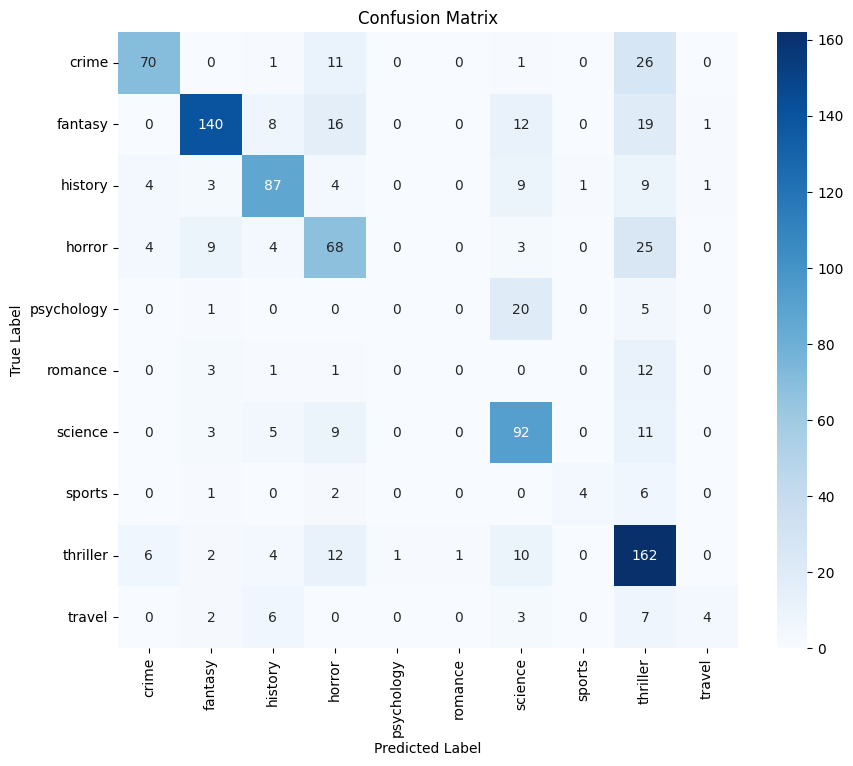

In [56]:
best_model = None
best_score = 0
best_vectorizer = None

for model_name, model_data in models.items():
    for vectorizer_name, vectorizer_data in vectorizers.items():
        print(model_name, vectorizer_name)
        vectorizer = vectorizer_data['vectorizer']
        model = model_data['model']
        
        pipeline = Pipeline([
            ('Vectorize', vectorizer),
            ('Model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        if pipeline.score(X_test, y_test) > best_score:
            best_score = pipeline.score(X_test, y_test)
            best_model = model_name
            best_vectorizer = vectorizer_name
            best_pipeline = pipeline

print(f'Best model: {best_model}')
print(f'Best vectorizer: {best_vectorizer}')

best_pipeline.fit(X_train, y_train)

print(f'accuracy_score: {accuracy_score(y_test, best_pipeline.predict(X_test))}\n')
print(f'Classification Report:\n{classification_report(y_test, best_pipeline.predict(X_test))}')
# Create a heatmap for the confusion matrix
conf_matrix = confusion_matrix(y_test, best_pipeline.predict(X_test))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Implementing it and trying to optimize the hyperparameters

              precision    recall  f1-score   support

       crime       0.83      0.55      0.66       109
     fantasy       0.86      0.73      0.79       196
     history       0.76      0.75      0.75       118
      horror       0.56      0.60      0.58       113
  psychology       0.50      0.04      0.07        26
     romance       0.00      0.00      0.00        17
     science       0.61      0.75      0.67       120
      sports       1.00      0.46      0.63        13
    thriller       0.55      0.82      0.66       198
      travel       1.00      0.18      0.31        22

    accuracy                           0.67       932
   macro avg       0.67      0.49      0.51       932
weighted avg       0.69      0.67      0.65       932



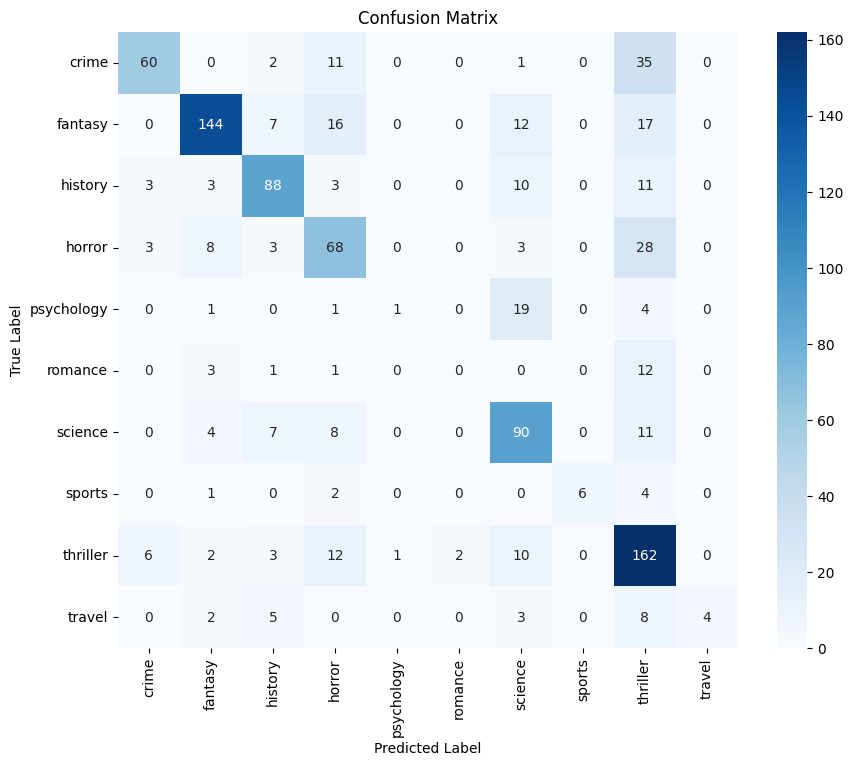

In [61]:
# instantiate the Model class with text and labels (X and y)
model_clf = Model(X, y, MultinomialNB(alpha=2, fit_prior= True), CountVectorizer())

# fit the model
model_clf.fit()

# predict and generate classification report
class_labels=label_encoder.inverse_transform(range(10))
model_clf.class_report(class_labels)

# Deep Learning Model with Tensorflow

After some tries with pyplot I decided to use Tensorflow which I already used in some other classes.

In [15]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, SimpleRNN, Flatten
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

In [88]:
sample_size = 1000

# Split the data into training and testing sets
X = df["pross_freq_rare"].iloc[:sample_size]
y = df['genre_enc'].iloc[:sample_size]

X_valid = df["pross_freq_rare"].iloc[sample_size : sample_size + 500]
y_valid = df['genre_enc'].iloc[sample_size : sample_size + 500]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42)

### Embedding the text datas

In [89]:
# Parameters
max_words = 10000
max_sequence_length = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train  = pad_sequences(X_train, maxlen=max_sequence_length)

X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_sequence_length)
X_valid = pad_sequences(tokenizer.texts_to_sequences(X_valid), maxlen=max_sequence_length)

### Simple Neural Network

In [41]:
def evaluate_model(model, X_test, y_test, threshold = 0.5):

    # Make predictions on test data
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba, axis=1)

    # Create a heatmap for the confusion matrix
    conf_matrix = confusion_matrix(y_test, prediction)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("Classficiation report: \n {}".format(classification_report(y_test, prediction)))
    return classification_report(y_test, prediction, output_dict=True)

In [95]:
# Parameters
embedding_dim = 32

# Create a Sequential model with Dense layers
model = keras.Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu', name='dense1'))
model.add(keras.layers.Dense(300, activation='relu', name='dense2'))
model.add(keras.layers.Dense(10, activation='softmax', name='proba'))

loss_fn_k = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Compile the model
model.compile(optimizer='adam', loss=loss_fn_k, metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor="loss", patience=3)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=5, batch_size=2, callbacks=[early_stopping])

Epoch 1/5
1746/1746 [==============================] - 31s 16ms/step - loss: 1.7555 - accuracy: 0.3225
Epoch 2/5
1746/1746 [==============================] - 27s 16ms/step - loss: 0.6824 - accuracy: 0.7626
Epoch 3/5
1746/1746 [==============================] - 28s 16ms/step - loss: 0.1940 - accuracy: 0.9447
Epoch 4/5
1746/1746 [==============================] - 28s 16ms/step - loss: 0.1055 - accuracy: 0.9719
Epoch 5/5
1746/1746 [==============================] - 27s 16ms/step - loss: 0.0959 - accuracy: 0.9719


37/37 [==============================] - 1s 13ms/step


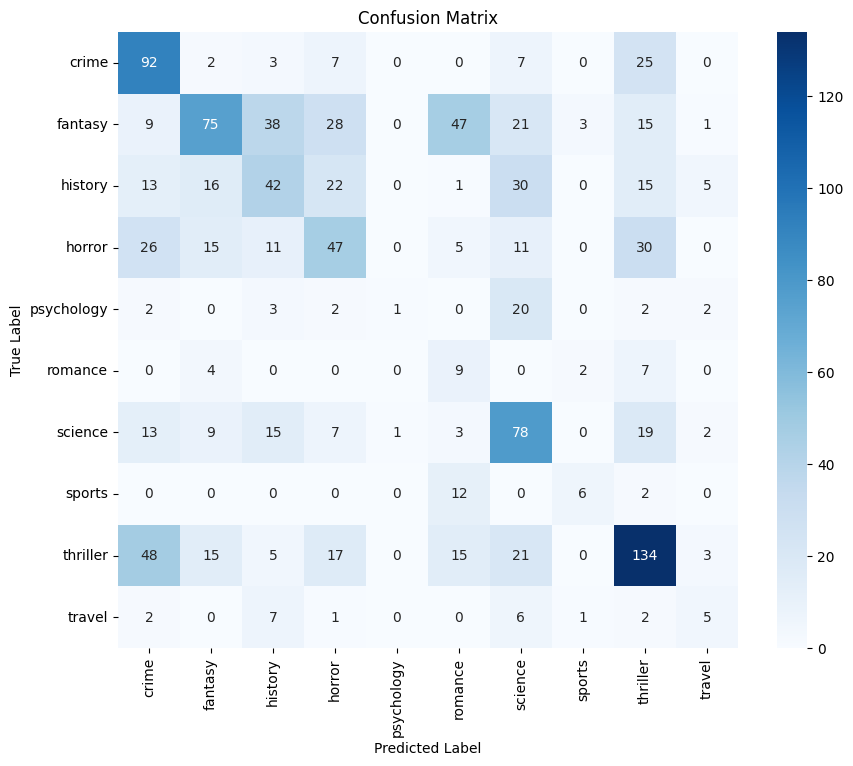

Classficiation report: 
               precision    recall  f1-score   support

           0       0.45      0.68      0.54       136
           1       0.55      0.32      0.40       237
           2       0.34      0.29      0.31       144
           3       0.36      0.32      0.34       145
           4       0.50      0.03      0.06        32
           5       0.10      0.41      0.16        22
           6       0.40      0.53      0.46       147
           7       0.50      0.30      0.37        20
           8       0.53      0.52      0.53       258
           9       0.28      0.21      0.24        24

    accuracy                           0.42      1165
   macro avg       0.40      0.36      0.34      1165
weighted avg       0.45      0.42      0.42      1165



In [96]:
# Evaluation of the model on test data
metrics = evaluate_model(model, X_test, y_test)

### RNN

In [69]:
from sklearn.model_selection import StratifiedKFold

Epoch 1/5
1863/1863 [==============================] - 111s 58ms/step - loss: 1.9201 - accuracy: 0.2258
Epoch 2/5
1863/1863 [==============================] - 114s 61ms/step - loss: 1.7193 - accuracy: 0.3605
Epoch 3/5
1863/1863 [==============================] - 123s 66ms/step - loss: 1.1368 - accuracy: 0.6370
Epoch 4/5
1863/1863 [==============================] - 108s 58ms/step - loss: 0.3918 - accuracy: 0.9055
Epoch 5/5
30/30 [==============================] - 1s 16ms/step


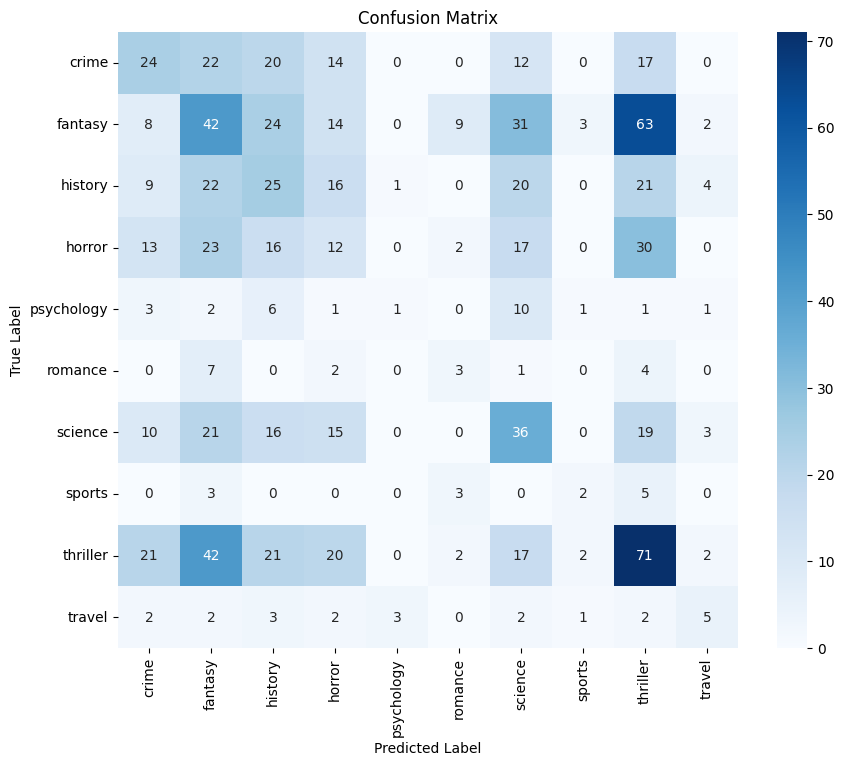

Classficiation report: 
               precision    recall  f1-score   support

           0       0.27      0.22      0.24       109
           1       0.23      0.21      0.22       196
           2       0.19      0.21      0.20       118
           3       0.12      0.11      0.11       113
           4       0.20      0.04      0.06        26
           5       0.16      0.18      0.17        17
           6       0.25      0.30      0.27       120
           7       0.22      0.15      0.18        13
           8       0.30      0.36      0.33       198
           9       0.29      0.23      0.26        22

    accuracy                           0.24       932
   macro avg       0.22      0.20      0.20       932
weighted avg       0.23      0.24      0.23       932



In [74]:
# Parameters
embedding_dim = 32
rnn_units = 32

# Create a Sequential model with RNN
modelRNN = keras.Sequential()
modelRNN.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
modelRNN.add(SimpleRNN(units=rnn_units))
modelRNN.add(Dense(10, activation='softmax', name='proba'))

# Compile the model
modelRNN.compile(optimizer='adam', loss=loss_fn_k, metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor="loss", patience=3)

# Train the modelRNN with early stopping
modelRNN.fit(X_train, y_train, epochs=5, batch_size=2, callbacks=[early_stopping])

# Evaluation of the model on test data
rnn_metrics = evaluate_model(modelRNN, X_test, y_test)

# Conclusion

I would like to conclude about the things I managed to do and the things I still need to improve, First : 

- Improving the model among time, 
- Understanding the main aspect and the main steps of NLP, 
- Doing a successful first model of Deep Learning by myself

Then : 
- Model accuracy could be improved by trying to add weight to the classes (I tried to do it but didn't manage to in the due time)
- Go more into details and try even more possible Deep Learning models and try to understand it even more so I can improve it, the score I managed to have are not really satisfying. 

Finally this project was really interesting for me as I want to work in ML in the future These first steps really helped me understand how it is done and how I can get better at it. I will in the future go deeper in my research and try to learn even more. 